# Preprocess the QPESUMS Data

The QPESUMS data were delivered in plain text format with names of `COMPREF.20160101.0010.txt` every 10 minutes. Here we want to aggregate hourly QPESUMS data for estimate the precipitation of the next hour, and hence some preprocessing utilities are required.

This notebook contains such functions along with testing scripts.

In [1]:
def search_qpesums_text(srcdir, prefix='COMPREF.', ext='.txt'):
    '''Search the specified the directory for QPESUMS data in text format and retrieve related information.
         example file name: COMPREF.20160101.0010.txt
    '''
    import os
    import pandas as pd
    fileinfo = []
    # Walk through the specified directory
    for root, dirs, files in os.walk(srcdir, followlinks=True):
        for f in files:
            if f.startswith(prefix) and f.endswith(ext):
                # Parse file name for time information
                furi = os.path.join(root, f)
                timestr = f.replace(prefix,'').replace(ext,'')
                # Append data
                fileinfo.append({'furi':furi, 'timestamp':timestr})
    # Return the results as a DataFrame
    results = pd.DataFrame(fileinfo).sort_values('timestamp').reset_index(drop=True)
    return(results)

def parse_time_string(tstr, fmt='%Y%m%d.%H%M'):
    '''Parse a time string into a datetime object. The given format was YYYYMMDD.HHMM.
       This function is separated in case the format of time-string might change over time.
    '''
    import datetime
    tobj = datetime.datetime.strptime(tstr, fmt)
    return(tobj)


In [2]:
# Test the file scaning function
srcdir = 'D:\data\qpedata\dbz'
finfo = search_qpesums_text(srcdir)
print('Total files found: '+str(finfo.shape[0]))
finfo.head(10)

Total files found: 51466


,furi,timestamp
0,D:\data\qpedata\dbz\20160101\COMPREF.20160101....,20160101.0010
1,D:\data\qpedata\dbz\20160101\COMPREF.20160101....,20160101.0020
2,D:\data\qpedata\dbz\20160101\COMPREF.20160101....,20160101.0030
3,D:\data\qpedata\dbz\20160101\COMPREF.20160101....,20160101.0040
4,D:\data\qpedata\dbz\20160101\COMPREF.20160101....,20160101.0050
5,D:\data\qpedata\dbz\20160101\COMPREF.20160101....,20160101.0100
6,D:\data\qpedata\dbz\20160101\COMPREF.20160101....,20160101.0120
7,D:\data\qpedata\dbz\20160101\COMPREF.20160101....,20160101.0140
8,D:\data\qpedata\dbz\20160101\COMPREF.20160101....,20160101.0150
9,D:\data\qpedata\dbz\20160101\COMPREF.20160101....,20160101.0200


In [3]:
# Test timestamp parsing
parse_time_string(finfo.timestamp.iloc[100])

datetime.datetime(2016, 1, 1, 17, 10)

## Test QPSUMS reading function

The QPESUMS data was delivered in *fixed-width-format* , and can be read in with:

`pd.read_fwf(furi, widths=[8,8,8], header=None)`



(275, 162)


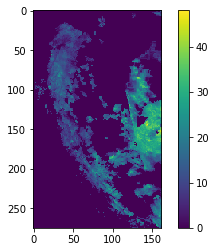

In [20]:
def read_qpesums_text(furi):
    import pandas as pd
    import numpy as np
    results = None
    try:
        tmp = pd.read_fwf(furi, widths=[8,8,8], header=None)
        results = np.float32(np.array(tmp.iloc[:,2])).reshape((275,162))
    except pd.errors.EmptyDataError:
        logging.error(furi + " is empty.")
    return(results)

tmp = read_qpesums_text(finfo.furi.iloc[1001])
print(tmp.shape)

%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(tmp)
plt.colorbar()
plt.show()

## Test grouping algorithm:

### pseudo code

Basically we want to loop through available time by hour, group data and then output.

```
data_info = search_qpesums_text(DATA_DIR)

start_time = the earliest time-stamp in data_info
end_time = the last time-stamp in data_info

current_time = start_time

while current_time < end_time:
    rec = aggregate_qpesums_data(current_time, data_info)
    output(rec)
    current_time += 10-min
```

And for `aggregate_qpesums_data()`, we want to:

- check the availability of involved data
- perform aggregation (y, x, t) if available
- time-zone conversion if necessary


In [56]:
def aggregate_qpesums_data(current_time, data_info, time_shift=0):
    ''' - check the availability of involved data
        - perform aggregation (y, x, t) if available
        - time-zone conversion if necessary
    '''
    from datetime import timedelta, date
    import numpy as np
    import pandas as pd
    # Get the previous 6 time-stamps with 10-min interval
    rec = {'timestamp': current_time.strftime("%Y%m%d.%H")}
    fcount = 0
    tslist = []
    for i in range(7,1,-1):
        ts = (current_time-timedelta(minutes=(i*10))).strftime("%Y%m%d.%H%M")
        # Check availability of required time-stamps
        rec['m-'+str((i-1)*10)] = (ts in data_info.timestamp.values)*1
        fcount += rec['m-'+str((i-1)*10)]
        tslist.append(ts)
    # Check data completeness
    rec['complete'] = (fcount==6)
    qdata = None
    if fcount==6:
        #print('Aggregate data for '+current_time.strftime("%Y%m%d.%H"))
        qdata = []
        for ts in tslist:
            qdata.append(read_qpesums_text(data_info.loc[data_info.timestamp==ts, 'furi'].iloc[0]))
        qdata =  np.stack(qdata, axis=2)
    # Shift time if necessary
    if time_shift !=0:
        rec['timestamp'] = (current_time+timedelta(hours=time_shift)).strftime("%Y%m%d.%H")
    return((rec, qdata))

# Testing
# Loop through time-stamps
tmp = finfo.iloc[:64,:]

starttime = parse_time_string(tmp.timestamp.iloc[0])
endtime = parse_time_string(tmp.timestamp.iloc[-1])

print(starttime)
print(endtime)

from datetime import timedelta, date

dcheck = []
qnpy = {}
ctime = starttime
while ctime <= endtime:
    tmp, data = aggregate_qpesums_data(ctime, finfo, time_shift=0)
    dcheck.append(tmp)
    if not data is None:
        qnpy[tmp['timestamp']] = np.array(data)
    ctime += timedelta(hours=1)

import pandas as pd
dcheck = pd.DataFrame(dcheck)
print(dcheck)

for k,v in qnpy.items():
    print(k + '    ' + str(v.shape))

2016-01-01 00:10:00
2016-01-01 11:00:00
      timestamp  m-60  m-50  m-40  m-30  m-20  m-10  complete
0   20160101.00     0     0     0     0     0     0     False
1   20160101.01     0     1     1     1     1     1     False
2   20160101.02     1     0     1     0     1     1     False
3   20160101.03     1     1     1     1     1     1      True
4   20160101.04     1     1     1     1     1     1      True
5   20160101.05     1     1     1     1     1     1      True
6   20160101.06     1     1     1     1     1     1      True
7   20160101.07     1     1     1     1     1     1      True
8   20160101.08     1     1     1     1     1     1      True
9   20160101.09     1     1     1     1     1     1      True
10  20160101.10     1     1     1     1     1     1      True
20160101.03    (275, 162, 6)
20160101.04    (275, 162, 6)
20160101.05    (275, 162, 6)
20160101.06    (275, 162, 6)
20160101.07    (275, 162, 6)
20160101.08    (275, 162, 6)
20160101.09    (275, 162, 6)
20160101.10  

In [57]:
# Try time_shift
dcheck = []
qnpy = {}
ctime = starttime
while ctime <= endtime:
    tmp, data = aggregate_qpesums_data(ctime, finfo, time_shift=8)
    dcheck.append(tmp)
    if not data is None:
        qnpy[tmp['timestamp']] = np.array(data)
    ctime += timedelta(hours=1)

import pandas as pd
dcheck = pd.DataFrame(dcheck)
print(dcheck)

for k,v in qnpy.items():
    print(k + '    ' + str(v.shape))

      timestamp  m-60  m-50  m-40  m-30  m-20  m-10  complete
0   20160101.08     0     0     0     0     0     0     False
1   20160101.09     0     1     1     1     1     1     False
2   20160101.10     1     0     1     0     1     1     False
3   20160101.11     1     1     1     1     1     1      True
4   20160101.12     1     1     1     1     1     1      True
5   20160101.13     1     1     1     1     1     1      True
6   20160101.14     1     1     1     1     1     1      True
7   20160101.15     1     1     1     1     1     1      True
8   20160101.16     1     1     1     1     1     1      True
9   20160101.17     1     1     1     1     1     1      True
10  20160101.18     1     1     1     1     1     1      True
20160101.11    (275, 162, 6)
20160101.12    (275, 162, 6)
20160101.13    (275, 162, 6)
20160101.14    (275, 162, 6)
20160101.15    (275, 162, 6)
20160101.16    (275, 162, 6)
20160101.17    (275, 162, 6)
20160101.18    (275, 162, 6)
